In [13]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_score, accuracy_score, classification_report
import pandas as pd
import itertools
import random
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm_notebook
from tqdm.contrib.itertools import product

plt.rcParams['text.usetex'] = True

In [2]:
class GassuianMixtureDistribuiton:

    def __init__(self, pos_prob, pos_mu, pos_std, neg_mu, neg_std):
        self.pos_prob = pos_prob
        self.pos_mu = pos_mu
        self.pos_std = pos_std
        self.neg_mu = neg_mu
        self.neg_std = neg_std

    def sample(self, n):
        y = np.random.binomial(1, self.pos_prob, n)
        x = (y == 1) * np.random.normal(self.pos_mu, self.pos_std, n) + (y == 0) * np.random.normal(self.neg_mu, self.neg_std, n)
        return x, y

    def sample_conditioned_on_y(self, n, y):
        x = (y == 1) * np.random.normal(self.pos_mu, self.pos_std, n) + (y == 0) * np.random.normal(self.neg_mu, self.neg_std, n)
        return x

In [6]:
#@title params { run: "auto" }
c_u = 0.8 #@param {type:"number"}
c_s = 0.4 #@param {type:"number"}
N = 10 #@param {type:"integer"}
seed = 0 #0 3 9 12 #@param {type:"integer"}

random.seed(seed)
np.random.seed(seed)

In [3]:
class LinearClassifier:

    def __init__(self, enc_z, b=0.5):
        self.enc_z = enc_z
        self.cls = LogisticRegression(penalty=None)
        self.b = b

    def prepare_data(self, Z, X):
        Z_onehot = self.enc_z.transform(Z.reshape(-1, 1)).toarray()
        return np.concatenate((Z_onehot, X.reshape(-1, 1)), axis=1)

    def fit(self, Z, X, Y):
        train_input = self.prepare_data(Z, X)
        self.cls.fit(train_input, Y)

    def __call__(self, Z, X):
        if len(Z) == 0:
            return np.array([])
        input = self.prepare_data(Z, X)
        probs = self.cls.predict_proba(input)
        return (probs[:, 1] > self.b).astype(int)

    def set_b(self, b):
        self.b = b



def get_classificaiton_statistics(Z, X, Y, cls):
    Yhat = cls(Z, X)
    dfs = []
    for z, y, yhat in itertools.product(Z_vals, [0, 1], [0, 1]):
        dfs.append(pd.DataFrame({
            "z": [z],
            "y": y,
            "yhat": yhat,
            "count": ((Z == z) & (Y == y) & (Yhat == yhat)).sum()
        }))
    stats = pd.concat(dfs)
    return stats


In [4]:
eps = 0.001

def precision(stats):
    if stats["count"].sum() == 0:
        return -1
    enum = stats[(stats.yhat == 1) & (stats.y == 1)]["count"].sum()
    denom = stats[stats.yhat == 1]["count"].sum() + eps
    return enum / denom


def accuracy(stats):
    if stats["count"].sum() == 0:
        return -1
    return stats[stats.yhat == stats.y]["count"].sum() / stats["count"].sum()


def will_apply(z, stats):
    return (precision(stats[stats.z == z]) > c_u).astype(float)


def get_applicaiton_decision_for_Z(Z, stats):
    A = np.zeros(len(Z))
    for z in Z_vals:
        A[Z == z] = will_apply(z, stats)
    return A


def get_induced_distribution(Z, X, Y, stats):
    Z_f_list, X_f_list, Y_f_list = [np.array([])], [np.array([])], [np.array([])]
    for z in np.unique(Z):
        if will_apply(z, stats):
            idx = np.where(Z == z)
            Z_f_list.append(Z[idx])
            X_f_list.append(X[idx])
            Y_f_list.append(Y[idx])
    return np.concatenate(Z_f_list), np.concatenate(X_f_list), np.concatenate(Y_f_list)


def system_utility(A, Yhat, Y):
    return (A * Yhat * (Y - c_s)).mean()

def system_utility_on_participating_users(A, Yhat, Y):
    return (Yhat * (Y - c_s))[A == 1].mean()

In [15]:
#@title Generate data { run: "auto" }
n_samples = 10000 #@param {type:"number"}
Z_vals = [*range(N)]

z_list, x_list, y_list = [], [], []
for z in Z_vals:
    # create random distribution
    pos_prob = np.random.random()
    pos_mu = np.random.uniform(0.5, 1)
    pos_std = np.random.uniform(0.2, 0.5)
    neg_mu = np.random.uniform(0, 0.5)
    neg_std = np.random.uniform(0.2, 0.5)
    dist = GassuianMixtureDistribuiton(pos_prob, pos_mu, pos_std, neg_mu, neg_std)
    # sample
    cur_n_samples = n_samples // N
    cur_Z = np.ones(cur_n_samples) * z
    cur_X, cur_Y = dist.sample(cur_n_samples)
    z_list.append(cur_Z)
    x_list.append(cur_X)
    y_list.append(cur_Y)

Z = np.concatenate(z_list)
X = np.concatenate(x_list)
Y = np.concatenate(y_list)

data = pd.DataFrame({"z": Z, "x": X, "y": Y, "row": Z // 3, "col": Z % 3})
g = sns.displot(data, x="x", hue="y", col="col", row="row", kind="kde", height=2)
axes = g.axes.flat
for ax, z in zip(axes, Z_vals):
    ax.set_title(f"z={z}")
for (i,j,k), data in g.facet_data():
        if data.empty:
            ax = g.facet_axis(i, j)
            ax.set_title("")
            ax.set_axis_off()

plt.show()


RuntimeError: Failed to process string with tex because latex could not be found

In [158]:
from sklearn.preprocessing import OneHotEncoder

enc_z = OneHotEncoder(handle_unknown='ignore')
enc_z.fit(Z.reshape(-1, 1))

cls = LinearClassifier(enc_z)
cls.fit(Z, X, Y)

In [159]:
dfs = []
b_values = np.linspace(0, 0.99, 100)
for b in tqdm_notebook(b_values):
    cls.set_b(b)
    Yhat = cls(Z, X)
    stats = get_classificaiton_statistics(Z, X, Y, cls)
    A = get_applicaiton_decision_for_Z(Z, stats)
    applications = [will_apply(z, stats) for z in Z_vals]
    Z_f, X_f, Y_f = get_induced_distribution(Z, X, Y, stats)
    Yhat_f = cls(Z_f, X_f)
    induced_stats = get_classificaiton_statistics(Z_f, X_f, Y_f, cls)

    data = {
            "acc": [accuracy(stats)],
            "prec": precision(stats),
            "induced_acc": accuracy(induced_stats),
            "induced_prec": precision(induced_stats),
            "mean_y_f": Y_f.mean(),
            "induced_util_s": system_utility(A, Yhat, Y),
            "induced_util_s_on_participating_users": system_utility_on_participating_users(A, Yhat, Y),
            "mean_apply": A.mean(),
            "mean_pass_screening": (A * Yhat).mean(),
            "b": b
        }
    for i in range(len(applications)):
        data[f"z{i}_apply"] = applications[i]
        data[f"z{i}_prec"] = precision(stats[stats.z == i])
    dfs.append(
        pd.DataFrame(data))
results = pd.concat(dfs)

  0%|          | 0/100 [00:00<?, ?it/s]

In [160]:
apply = np.asarray([int(np.any(results[f"z{i}_prec"].values-c_u>0)) for i in Z_vals])
apply_at = np.asarray([np.argmax(results[f"z{i}_prec"].values-c_u>0) for i in Z_vals])
apply_at = (100*(1-apply)+apply_at)/100
order_inv = np.argsort(apply_at)
apply_at_ord = np.asarray([apply_at[i] for i in order_inv[::-1]])

base_rates = [results[f"z{i}_prec"].values[0] for i in Z_vals]
base_rates_ord = [base_rates[i] for i in order_inv[::-1]]

x_ = results["b"]
ys_ = np.asarray([results[f"z{i}_prec"].replace(0,None) for i in Z_vals])
ys_ = ys_[order_inv,:]

order_br = np.argsort(-np.asarray(ys_[:,0]))
idx_br = np.zeros(N).astype(np.int32)
idx_br[order_br] = np.arange(N)

In [162]:
path = '../../graphics/'
SAVE = True

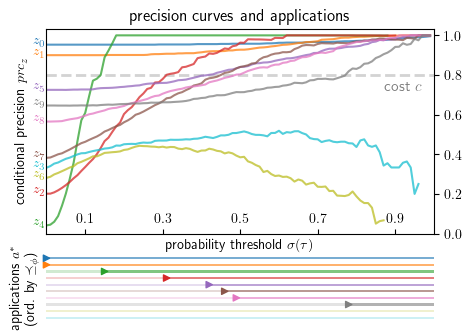

In [163]:
fig = plt.figure() #(constrained_layout=True)
fig.set_size_inches(5,3.8)
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[0.75, 0.25], hspace=0.15)


lines_cmap = plt.get_cmap('tab10')
colors = [lines_cmap(i) for i in range(lines_cmap.N)]
colors_ord = [colors[i] for i in order_inv[::-1]]

axs = [[]]*2

axs[0] = fig.add_subplot(spec[0])
axs[0].axhline(y=c_u, linestyle='--', linewidth=2, color='lightgrey', label="users cost")
for z in Z_vals:
    axs[0].plot(x_, ys_[z,:], alpha=0.75)
for i,z in enumerate(Z_vals):
    axs[0].text(-0.035, ys_[z,0], r"$z_{}$".format(idx_br[i]), color=colors[i])
axs[0].text(0.87, c_u-0.08, r'cost $c$', color='grey', fontsize=11)
axs[0].set_title('precision curves and applications')
axs[0].set_xlim(0,1)
axs[0].set_ylim(0,1.03)
axs[0].set_xlabel(r'probability threshold $\sigma(\tau)$')
# axs[0].xaxis.set_label_coords(0.5,0.2)
axs[0].tick_params(axis='x',direction='in', pad=-15)
axs[0].set_xticks(np.arange(0.1,1,0.2))
axs[0].set_ylabel(r'conditional precision $prc_z$')
axs[0].yaxis.set_label_coords(-0.05,0.5)
# axs[0].yaxis.set_label_position("right")
axs[0].yaxis.tick_right()
# axs[0].get_xaxis().set_visible(False)

axs[1] = fig.add_subplot(spec[1])
full = np.ones(apply_at.shape)
axs[1].barh(Z_vals, apply_at_ord, 0.35, color=colors[::-1], alpha=0.217)
axs[1].barh(Z_vals, full-apply_at_ord, 0.35, left=apply_at_ord, color=colors[::-1], alpha=0.6)
idx = np.where(np.asarray(apply_at_ord)<1)[0]
sctr = axs[1].scatter(apply_at_ord[idx], np.asarray(Z_vals)[idx], marker='>', s=20, c=np.asarray(colors[::-1])[idx], zorder=3)
sctr.set_clip_on(False)
# axs[1].set_xlabel(r'probability threshold $\sigma(\tau)$')
axs[1].set_ylabel(r'applications $a^*$' + '\n' + r'(ord. by $\preceq_\phi$)', multialignment='center')
axs[1].yaxis.set_label_coords(-0.02,0.5)
axs[1].spines['left'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].set_yticks([])
axs[1].set_xticks([])
# axs[1].get_yaxis().set_visible(False)

if SAVE:
    plt.savefig(path + '/precs+apps.pdf', format='pdf')
    plt.savefig(path + '/precs+apps.png', format='png')
else:
    plt.show()